In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks/PhD Test'

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-578125d16dd7>", line 1, in <cell line: 1>
    get_ipython().run_line_magic('cd', "'/content/drive/MyDrive/Colab Notebooks/PhD Test'")
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-pac

In [3]:
import train
from preprocess_data import read_data, preprocess
import yaml
import matplotlib.pyplot as plt
from utils.train_utils import apply_transform, prepare_models, prepare_objectives, prepare_dataloaders
import inference
from utils.train_utils import save_model_to_matlab
import numpy as np
import torch

In [4]:
config_file = ['default.yaml', 'sequence.yaml'][0]
config_path = '/content/drive/MyDrive/Colab Notebooks/PhD Test/configs/' + config_file

with open(config_path,'r') as f:
    config = yaml.safe_load(f)
print(config)

{'data_path': '/content/drive/MyDrive/Colab Notebooks/PhD Test/data/data-learning-control-room-temperature.zip', 'sequence': False, 'horizon': 10, 'model_alpha': 0.1, 'random_split': True, 'split_ratio': '0.7 0.1 0.2', 'batch_size': 64, 'model': 'fcn', 'optimizer': 'SGD', 'learning_rate': 0.01, 'scheduler': 'ReduceLROnPlateau', 'T_max': 10, 'step_size': 30, 'gamma': 0.1, 'num_epochs': 10, 'device': 'cpu', 'continue_training': False, 'trained_weights': '', 'save_checkpoint': '/content/drive/MyDrive/Colab Notebooks/PhD Test/checkpoints/all_states.pt', 'save_model_checkpoint': '/content/drive/MyDrive/Colab Notebooks/PhD Test/checkpoints/model_weights.pt', 'save_matlab_checkpoint': '/content/drive/MyDrive/Colab Notebooks/PhD Test/checkpoints/matlab_weights.mat'}


In [5]:
data = read_data(config)

In [6]:
data.sort_values('time',inplace = True)

In [7]:
data.head()

,time,room_temp,supply_temp,htg_setpoint,airflow_current,htg_mode
0,2021-04-26T09:37:00.0,72.3,59.3,68.5,416,False
1,2021-04-26T09:38:00.0,72.2,58.8,68.5,413,False
2,2021-04-26T09:39:00.0,72.2,58.5,68.5,419,False
3,2021-04-26T09:40:00.0,72.1,58.2,68.5,410,False
4,2021-04-26T09:41:00.0,71.9,58.1,68.5,404,False


In [8]:
data.tail()

,time,room_temp,supply_temp,htg_setpoint,airflow_current,htg_mode
5742,2021-04-30T09:19:00.0,71.9,79.1,71.0,549,True
5743,2021-04-30T09:20:00.0,71.9,78.3,71.0,552,True
5744,2021-04-30T09:21:00.0,71.9,77.8,71.0,555,True
5745,2021-04-30T09:22:00.0,71.7,77.6,71.0,546,True
5746,2021-04-30T09:23:00.0,71.7,77.6,71.0,549,True


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5747 entries, 0 to 5746
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             5747 non-null   object 
 1   room_temp        5747 non-null   float64
 2   supply_temp      5747 non-null   float64
 3   htg_setpoint     5747 non-null   float64
 4   airflow_current  5747 non-null   int64  
 5   htg_mode         5747 non-null   bool   
dtypes: bool(1), float64(3), int64(1), object(1)
memory usage: 275.0+ KB


In [10]:
data.describe()

,room_temp,supply_temp,htg_setpoint,airflow_current
count,5747.000000,5747.000000,5747.000000,5747.000000
mean,71.695232,76.374926,71.342266,592.639116
std,1.689533,13.072332,1.921776,157.064136
min,68.500000,56.200000,68.000000,394.000000
25%,70.200000,58.500000,70.000000,435.000000
50%,71.600000,79.500000,71.500000,574.000000
75%,73.100000,87.200000,73.000000,704.000000
max,75.700000,97.000000,76.000000,1003.000000


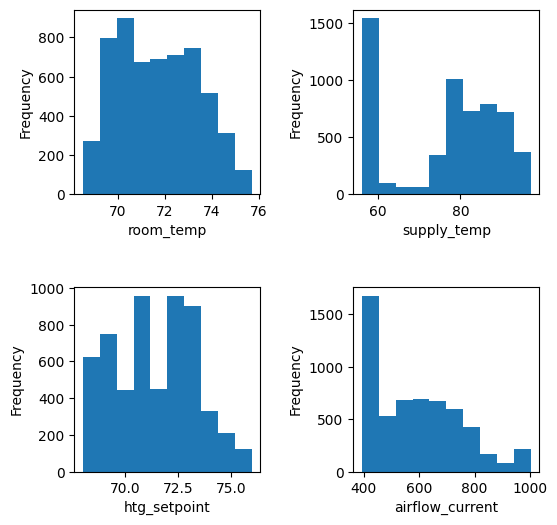

In [11]:
num_cols = len(data.select_dtypes(include='number').columns)
fig, axs = plt.subplots(int(num_cols/2),2, figsize=(6, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(data.select_dtypes(include='number').columns):
    r = i//2
    c = i%2
    axs[r][c].hist(data[col])
    axs[r][c].set_xlabel(col)
    axs[r][c].set_ylabel('Frequency')
plt.show()


In [12]:
data_processed, X_scaler, y_scaler = preprocess(config)

In [13]:
data_processed['x_train'].shape

(4136, 3)

In [14]:
print(X_scaler.data_min_)
print(X_scaler.data_max_)

[ 68.5  56.2 394. ]
[  75.7   97.  1003. ]


In [15]:
print(y_scaler.data_max_)
print(y_scaler.data_min_)

[75.7]
[68.5]


In [16]:
train_transform, valid_transform = apply_transform(config)

training_loader, validation_loader = prepare_dataloaders(
    config, data_processed, train_transform, valid_transform)


In [17]:
model = prepare_models(config)
model.to(config['device'])

FCNModel(
  (linear1): Linear(in_features=3, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (silu1): SiLU()
  (silu2): SiLU()
)

In [18]:
criterion, optimizer, scheduler = prepare_objectives(config, model)


In [19]:
lr = optimizer.param_groups[0]['lr']
print("Current learning rate:", lr)
opt_name = optimizer.__class__.__name__
print("Optimizer name:", opt_name)

Current learning rate: 0.01
Optimizer name: SGD


In [20]:
if config['continue_training']:
    model.load_state_dict(torch.load(
        config['trained_weights'])['model_state_dict'])
    epoch = torch.load(config['trained_weights'])['epoch']
else:
    epoch = 0

train_loss_list, valid_loss_list = \
                    train.train_and_evaluate(config, training_loader, validation_loader,
                    model, criterion, optimizer, scheduler, epoch)

----------------------------------------------------------------------------------------------
Epoch: 1 | Epoch Time: 0m 0s
Training
	 MSE Loss: 0.02689878 | R2 score: 0.50497 | RMSE loss: 0.15856281
Validating
	 MSE Loss: 0.01731025 |  R2 score: 0.68460 | RMSE loss: 0.13098362
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 2 | Epoch Time: 0m 0s
Training
	 MSE Loss: 0.01635854 | R2 score: 0.69904 | RMSE loss: 0.12741695
Validating
	 MSE Loss: 0.01612910 |  R2 score: 0.71982 | RMSE loss: 0.12629515
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 3 | Epoch Time: 0m 1s
Training
	 MSE Loss: 0.01386067 | R2 score: 0.74591 | RMSE loss: 0.11725229
Validating
	 MSE Loss: 0.01283832 |  R2 score: 0.76878 | RMSE loss: 0.11288528
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 4 | Epoch Time: 0m 1s
Training
	 MSE Loss: 0.01198854 | R2 score: 0.77899 | RMSE loss: 0.10902193
Validating
	 MSE Loss: 0.01114611 |  R2 score: 0.80021 | RMSE loss: 0.10531682
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 5 | Epoch Time: 0m 1s
Training
	 MSE Loss: 0.01050965 | R2 score: 0.80704 | RMSE loss: 0.10224722
Validating
	 MSE Loss: 0.00951050 |  R2 score: 0.81927 | RMSE loss: 0.09716038
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 6 | Epoch Time: 0m 2s
Training
	 MSE Loss: 0.00924243 | R2 score: 0.82741 | RMSE loss: 0.09587261
Validating
	 MSE Loss: 0.00881910 |  R2 score: 0.84388 | RMSE loss: 0.09327143
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 7 | Epoch Time: 0m 2s
Training
	 MSE Loss: 0.00812563 | R2 score: 0.85062 | RMSE loss: 0.08984031
Validating
	 MSE Loss: 0.00723474 |  R2 score: 0.86704 | RMSE loss: 0.08450931
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 8 | Epoch Time: 0m 2s
Training
	 MSE Loss: 0.00714817 | R2 score: 0.86803 | RMSE loss: 0.08417532
Validating
	 MSE Loss: 0.00695086 |  R2 score: 0.86133 | RMSE loss: 0.08306627
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 9 | Epoch Time: 0m 3s
Training
	 MSE Loss: 0.00627063 | R2 score: 0.88392 | RMSE loss: 0.07879879
Validating
	 MSE Loss: 0.00557170 |  R2 score: 0.89744 | RMSE loss: 0.07394460
----------------------------------------------------------------------------------------------




----------------------------------------------------------------------------------------------
Epoch: 10 | Epoch Time: 0m 4s
Training
	 MSE Loss: 0.00548154 | R2 score: 0.89881 | RMSE loss: 0.07373919
Validating
	 MSE Loss: 0.00535834 |  R2 score: 0.89877 | RMSE loss: 0.07292888
----------------------------------------------------------------------------------------------




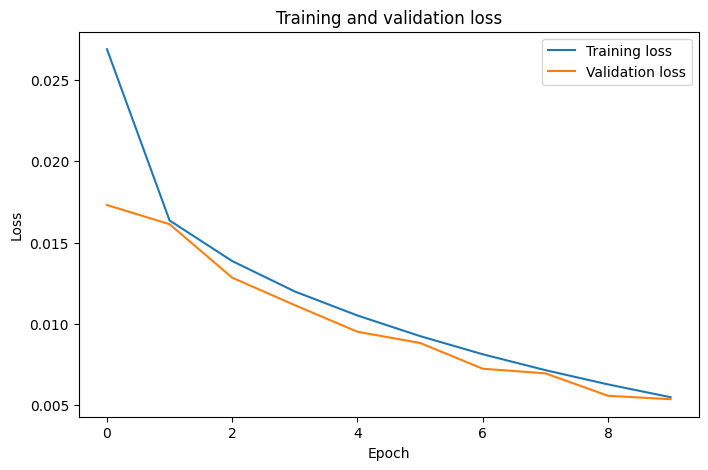

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(train_loss_list, label='Training loss')
ax.plot(valid_loss_list, label='Validation loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [22]:

#save_model_to_matlab(config,model)


	 R2 score: 0.90433 |  MSE Loss: 0.26057367 |  RMSE loss: 0.51046417


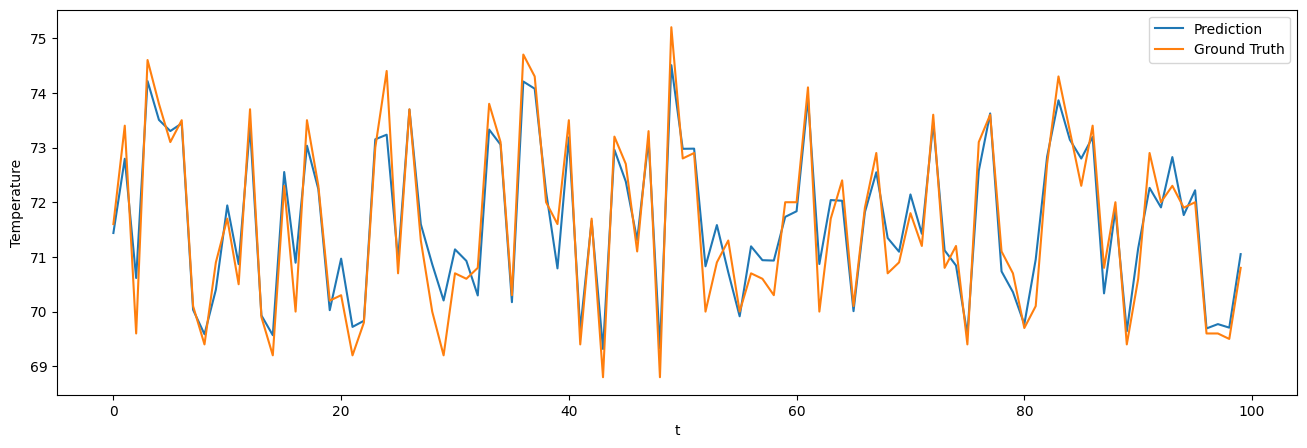

In [23]:
y_true, y_pred = inference.infer_numpy_data(data_processed, model, X_scaler, y_scaler,config)
n = 100
f_size = (10,10) if config['sequence'] else (16,5)
inference.plot_data(y_true,y_pred,n,config,f_size)

In [24]:
test_dataloader = inference.prepare_test_loader(config,data_processed)
rmse, mse, r2_score  = inference.infer_data(config, model, test_dataloader, y_scaler)


	 R2 score: 0.90177 |  MSE Loss: 0.26048492 |  RMSE loss: 0.50918606
